## Finetuning EfficientNet B0

In [ ]:
import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cpu
torchvision version: 0.21.0+cpu


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Using Modularized implementation of ViT -- ENGINE
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
set_seeds() # reproducibility

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load ResNet-50 with pretrained weights
resnet_weights = torchvision.models.ResNet50_Weights.DEFAULT
pretrained_resnet = torchvision.models.resnet50(weights=resnet_weights).to(device)

# Freeze all layers
for param in pretrained_resnet.parameters():
    param.requires_grad = False


In [ ]:

# Replace the classifier head (original out_features = 1000)
num_classes = 2
pretrained_resnet.fc = nn.Linear(in_features=pretrained_resnet.fc.in_features,
                                 out_features=num_classes).to(device)

In [ ]:
# Model Summary
summary(model=pretrained_resnet,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
!pip install gdown
!gdown --id 1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn -c
!unzip -q -n WildRF.zip

from pathlib import PosixPath
image_path = PosixPath("WildRF")
train_dir = image_path / "train"
test_dir = image_path / "val"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Skipping already downloaded file WildRF.zip


In [ ]:
# Get automatic transforms for ResNet-50
resnet_transforms = resnet_weights.transforms()
print(resnet_weights)
print(resnet_transforms)

EfficientNet_B2_Weights.IMAGENET1K_V1
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
# Create dataloaders using custom data_setup module
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=resnet_transforms,
    batch_size=32
)

In [ ]:
import going_modular.going_modular.engine
print(going_modular.going_modular.engine.__file__)

/content/going_modular/going_modular/engine.py


In [ ]:
from importlib import reload
reload(going_modular.going_modular.engine)

<module 'going_modular.going_modular.engine' from '/content/going_modular/going_modular/engine.py'>

In [ ]:
from going_modular.going_modular import engine

# Optimizer and Loss
optimizer = torch.optim.Adam(params=pretrained_resnet.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Set seeds and train
set_seeds()

# Train for 10 epochs
pretrained_resnet_results = engine.train(
    model=pretrained_resnet,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

# Save model and optimizer
torch.save({
    'model_state_dict': pretrained_resnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, '/content/gdrive/MyDrive/pretrained_resnet50_checkpoint_epoch10.pth')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5026 | train_acc: 0.7750 | test_loss: 0.3921 | test_acc: 0.8503
Epoch: 2 | train_loss: 0.3780 | train_acc: 0.8428 | test_loss: 0.3477 | test_acc: 0.8575
Epoch: 3 | train_loss: 0.3599 | train_acc: 0.8538 | test_loss: 0.3346 | test_acc: 0.8671
Epoch: 4 | train_loss: 0.3173 | train_acc: 0.8701 | test_loss: 0.3168 | test_acc: 0.8671
Epoch: 5 | train_loss: 0.3190 | train_acc: 0.8750 | test_loss: 0.3109 | test_acc: 0.8695


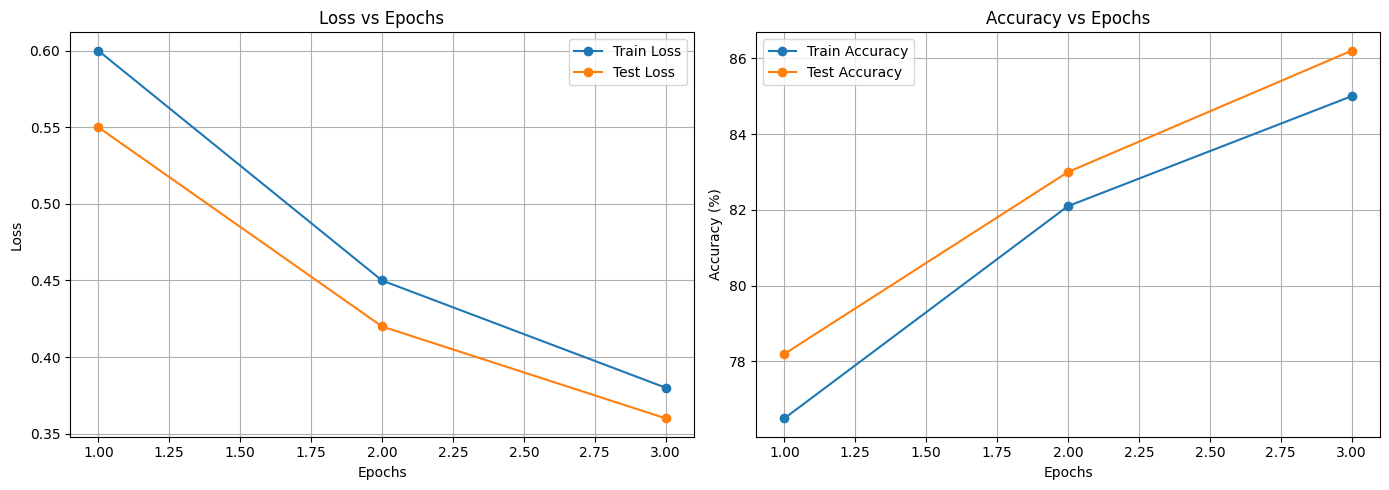

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_resnet_results)
